In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import SimpleITK as sitk

import os, glob
import cv2
import pandas as pd


from collections import OrderedDict
from read_roi import read_roi_zip 

In [2]:
"""
resmapling code: pixel spacing, slice thickness 맞추는 용도
"""

def resample_img(itk_image, out_spacing=[1.0, 1.0, 1.0], is_label=False):
    
    original_spacing = itk_image.GetSpacing()
    original_size = itk_image.GetSize()
    
    #original_spacing = original_spacing
    #print("original_spacing :", original_spacing)
    
    #original_size = original_size
    #print("original_size :", original_size)

    out_size = [
        int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))), # x,y axis 수정
        int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
        int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))]

    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(out_spacing)
    resample.SetSize(out_size)
    resample.SetOutputDirection(itk_image.GetDirection())
    resample.SetOutputOrigin(itk_image.GetOrigin())
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
        
    return resample.Execute(itk_image)


def win_scale(data, wl, ww, dtype, out_range):
    """
    Scale pixel intensity data using specified window level, width, and intensity range.
    """
    
    data_new = np.empty(data.shape, dtype=np.double)
    data_new.fill(out_range[1]-1)
    
    data_new[data <= (wl-ww/2.0)] = out_range[0]
    
    data_new[(data>(wl-ww/2.0))&(data<=(wl+ww/2.0))] = ((data[(data>(wl-ww/2.0))&(data<=(wl+ww/2.0))]-(wl-0.5))/(ww-1.0)+0.5)*(out_range[1]-out_range[0])+out_range[0]
    
    data_new[data > (wl+ww/2.0)] = out_range[1]-1
    
    return data_new.astype(dtype)

In [19]:
"""
시작점, 끝점 불러오기 위한 엑셀 리스트
"""
dvt_list_origin = pd.read_excel('../../newData/DVT_list_210215.xlsx', engine='openpyxl',sheet_name='DVT_origin')
dvt_list_add = pd.read_excel('../../newData/DVT_list_210215.xlsx', engine='openpyxl',sheet_name='DVT_add_180')
dvt_list_normal = pd.read_excel('../../newData/DVT_list_210215.xlsx', engine='openpyxl',sheet_name='Normal_180')

In [18]:
"""
check one
"""
dcm_Study_date = '20180920'
one_id = dvt_list_add.index[dvt_list_add['ID'] == 1524603]
print(len(one_id))
print(one_id[0], one_id[1])

for oi in one_id:
    if dvt_list_add['Study Date'][oi].date().strftime('%Y%m%d')== str(dcm_Study_date):
        start_point = dvt_list_add['시작'][oi]
        end_point = dvt_list_add['끝'][oi]
print(start_point, end_point)

2
3 4
33 124


In [80]:
##check one 0216
ReSize= 0.891

kinds= 'abnormal'
op = 0
one_p = sorted(glob.glob('../../newData/210215/{}/*'.format(kinds)))


p_name=one_p[op].split('\\')[-1][:8]


dcm_list = sorted(glob.glob('../../newData/210215/abnormal/00425493_201007/*.dcm'))   
dcm_vol = sitk.ReadImage(dcm_list)

print(dcm_vol.GetSpacing())
# pixcel spacing 맞추는 부분
origin_dcm = resample_img(dcm_vol, out_spacing=[dcm_vol.GetSpacing()[0], dcm_vol.GetSpacing()[1], dcm_vol.GetSpacing()[2]], is_label=False)
recon_dcm = resample_img(dcm_vol, out_spacing=[ReSize, ReSize, dcm_vol.GetSpacing()[2]], is_label=False)
recon_dcm_array = win_scale(sitk.GetArrayFromImage(recon_dcm), 140, 400, np.uint8, (0,255))
origin_dcm_array = win_scale(sitk.GetArrayFromImage(origin_dcm), 140, 400, np.uint8, (0,255))

print(origin_dcm_array.shape,recon_dcm_array.shape)

file_reader = sitk.ImageFileReader()
file_reader.SetFileName(dcm_list[0])
file_reader.ReadImageInformation()

for key in file_reader.GetMetaDataKeys():
    print(key + ': ' + file_reader.GetMetaData(key))
    print('-' * 20)
###### 시작점과 끝점 불러오기   
##################  origin data                                                                      
if len(one_p[op].split('/')[-1])<11:
    one_id_index = dvt_list_origin.index[dvt_list_origin['ID'] == int(p_name)]
    if len(one_p[op].split('/')[-1])<9:
        start_point = dvt_list_origin['시작'][one_id_index]
        end_point = dvt_list_origin['끝'][one_id_index]

    else:
        
        dcm_Study_date = file_reader.GetMetaData('0018|1200')
        print(dcm_Study_date)
        for oi in one_id_index:
            if dvt_list_add['Study Date'][oi].date().strftime('%Y%m%d')== str(dcm_Study_date):
                start_point = dvt_list_origin['시작'][oi]
                end_point = dvt_list_origin['끝'][oi]
            else:
                continue
##################  add data 
else:
    one_id_index = dvt_list_add.index[dvt_list_add['ID'] == int(p_name)]
    file_Study_date = one_p[op].split('\\')[-1][8:]
    dcm_Study_date = file_reader.GetMetaData('0018|1200')
    print(file_Study_date, dcm_Study_date)
    for oi in one_id_index:
        print('oi',oi)
        if dvt_list_add['Study Date'][oi].date().strftime('%Y%m%d')== str(dcm_Study_date):
            start_point = dvt_list_add['시작'][oi]
            end_point = dvt_list_add['끝'][oi]
        else:
            continue

print(int(p_name),one_id_index)
print(dvt_list_add['Study Date'][one_id_index[0]].date().strftime('%Y%m%d'))
print(start_point, end_point)



    

# for trd in range(54,57):
#     plt.figure()
#     plt.subplot(1,2,1)
#     plt.imshow(origin_dcm_array[trd], cmap='gray')
#     plt.subplot(1,2,2)
#     plt.imshow(recon_dcm_array[trd], cmap='gray')

(0.841796875, 0.841796875, 5.0)
(252, 512, 512) (252, 484, 484)
0008|0005: ISO_IR 100
--------------------
0008|0008: ORIGINAL\PRIMARY\AXIAL\CT_SOM5 SPI
--------------------
0008|0016: 1.2.840.10008.5.1.4.1.1.2
--------------------
0008|0018: 1.3.12.2.1107.5.1.4.60352.30000020100623061484700062326
--------------------
0008|0020: 20201007
--------------------
0008|0021: 20201007
--------------------
0008|0022: 20201007
--------------------
0008|0023: 20201007
--------------------
0008|002a: 20201007151820.485000 
--------------------
0008|0030: 151019.231000 
--------------------
0008|0031: 151852.421000 
--------------------
0008|0032: 151820.485000 
--------------------
0008|0033: 151820.485000 
--------------------
0008|0050: 004254939517175 
--------------------
0008|0060: CT
--------------------
0008|0070: SIEMENS 
--------------------
0008|0080: GACHON UNIV.GMC 
--------------------
0008|0081: Namdong-gu, Guwoldong
/F3DC3E/
Incheon
KR
--------------------
0008|0090: BAEK KIL YOON 

In [101]:
p_name= '00266642'

one_id_index = dvt_list_normal.index[dvt_list_normal['ID'] == int(p_name)]
print(one_id_index[0])
print(len(one_id_index))

print(dvt_list_normal['ID'][one_id_index[0]],dvt_list_normal['시작'][75], dvt_list_normal['끝'][75])

75
1
266642 46 139


0069-0287-0322 181
{'type': 'rectangle', 'left': 317, 'top': 280, 'width': 11, 'height': 15, 'arc_size': 0, 'name': '0069-0287-0322', 'position': 69}
69
317
280
0.9447776374859708
11 10


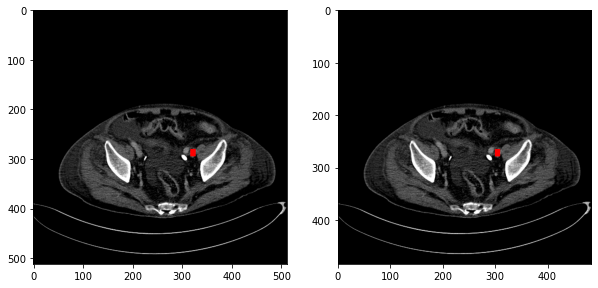

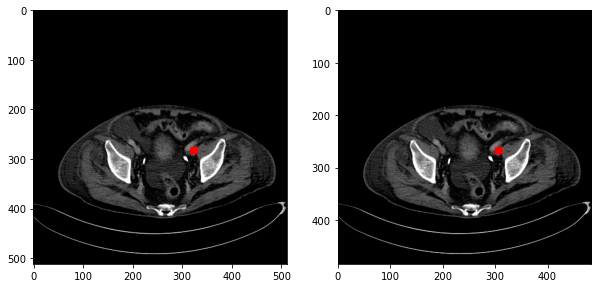

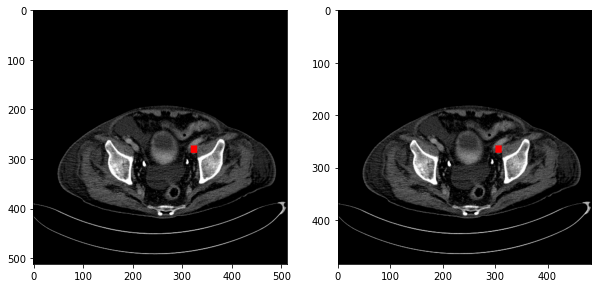

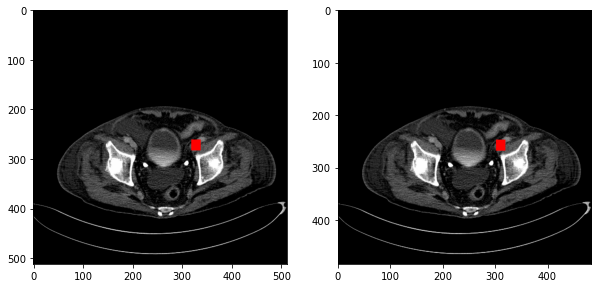

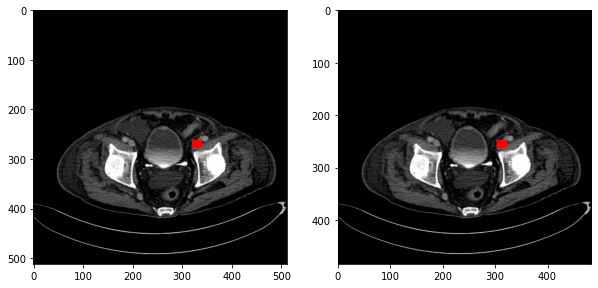

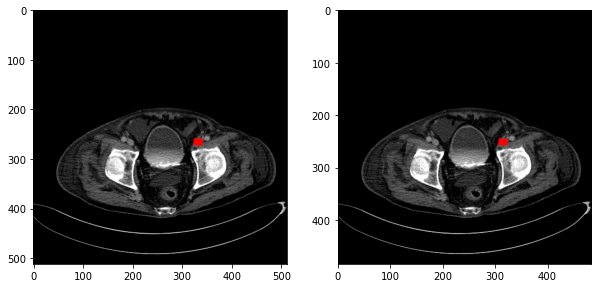

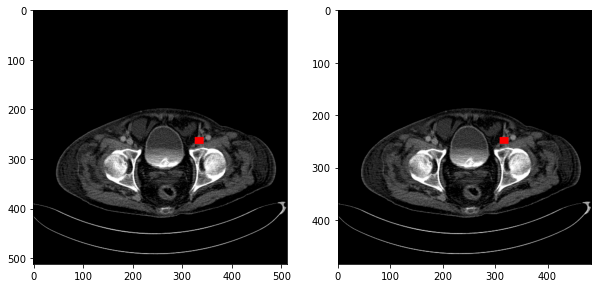

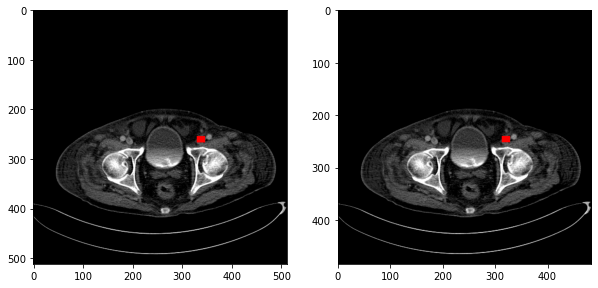

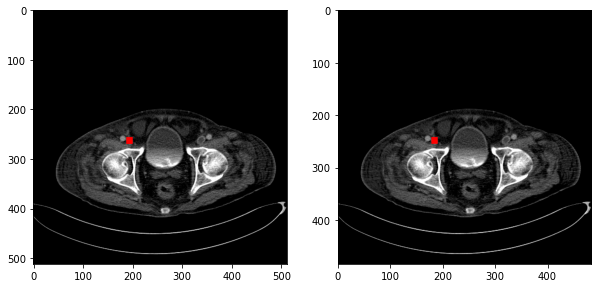

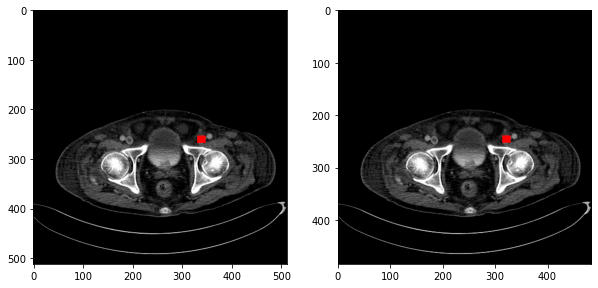

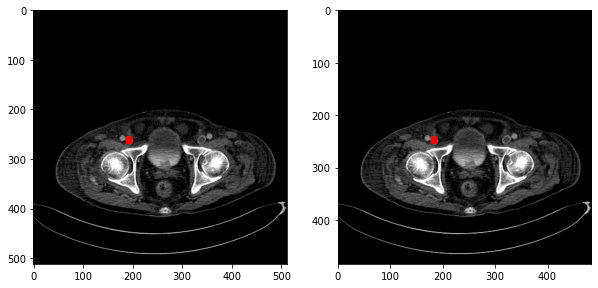

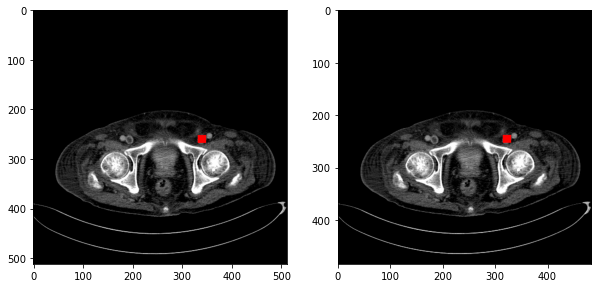

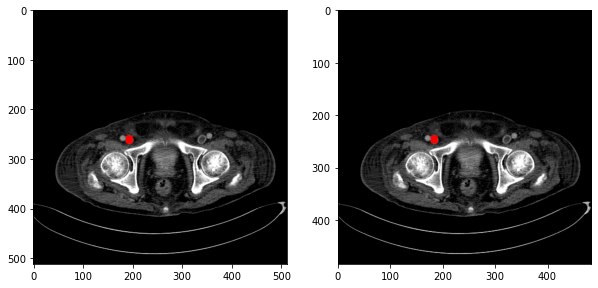

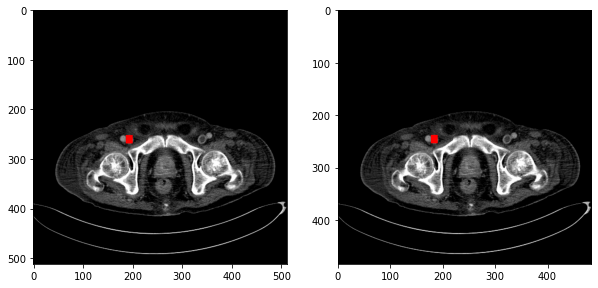

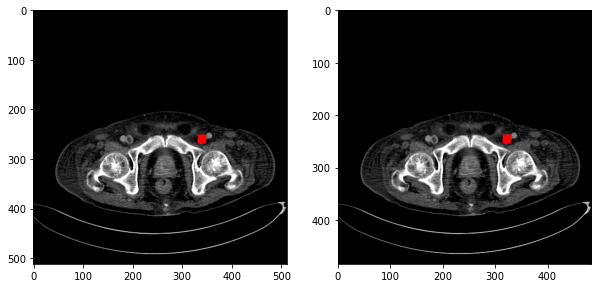

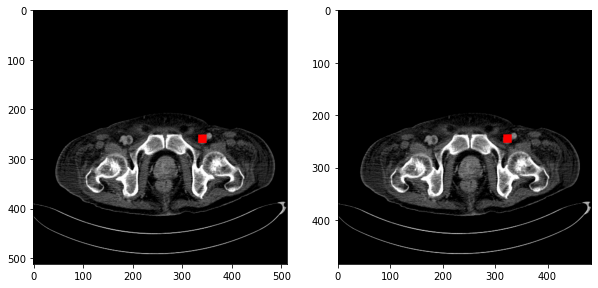

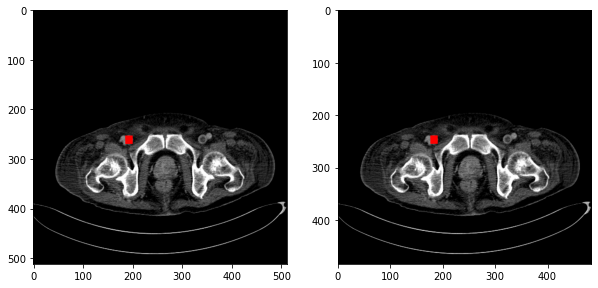

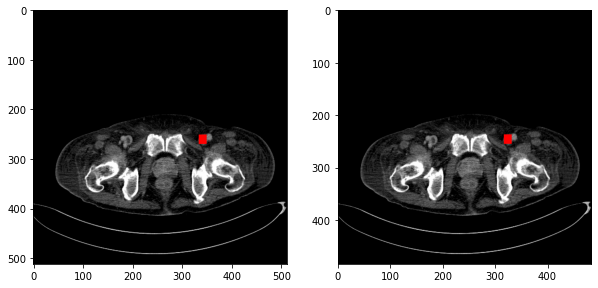

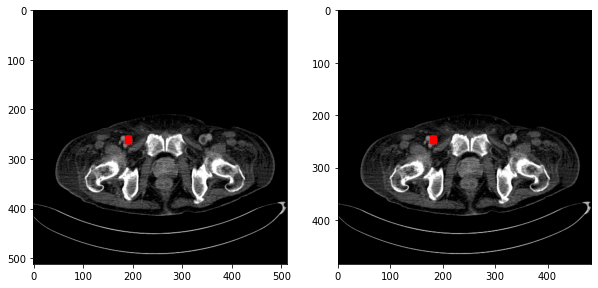

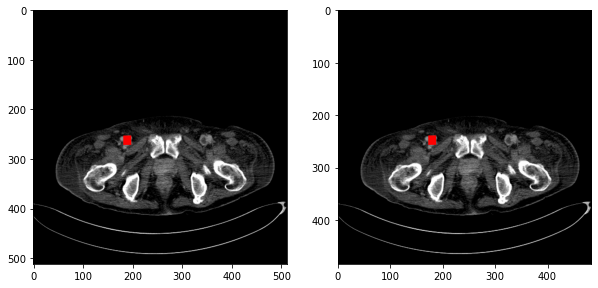

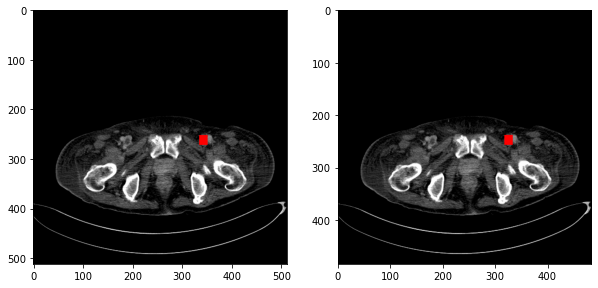

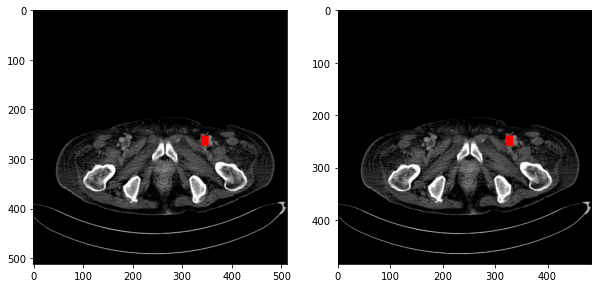

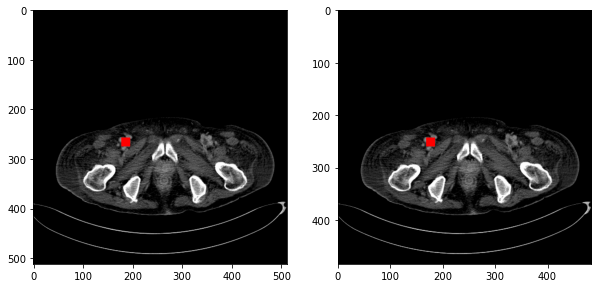

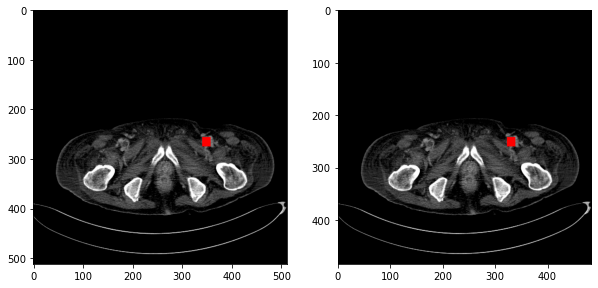

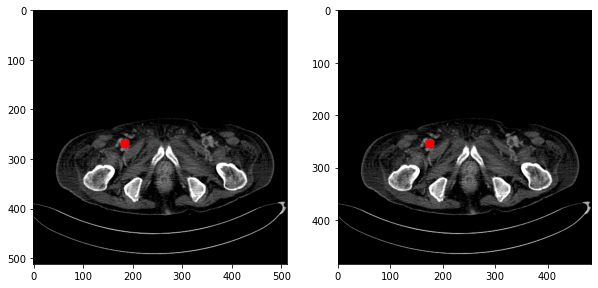

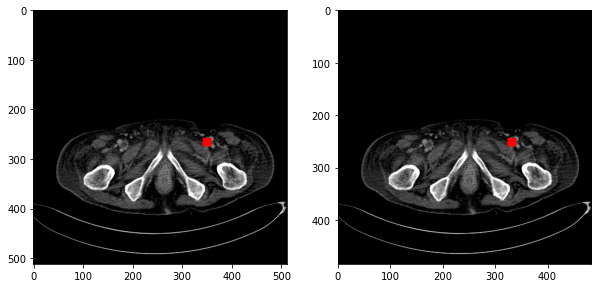

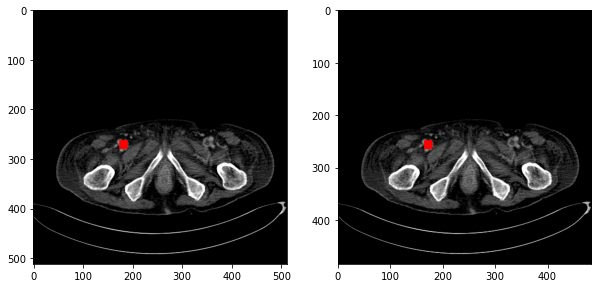

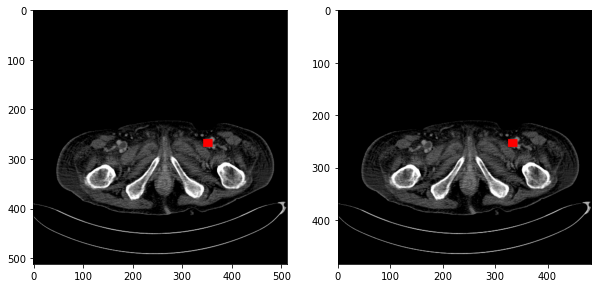

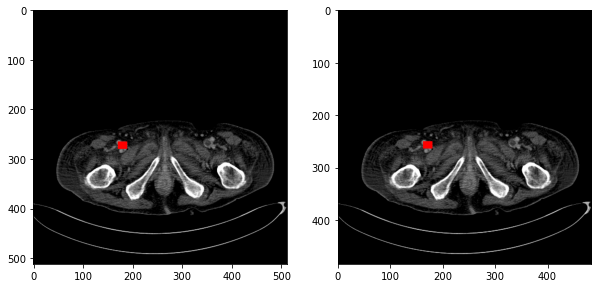

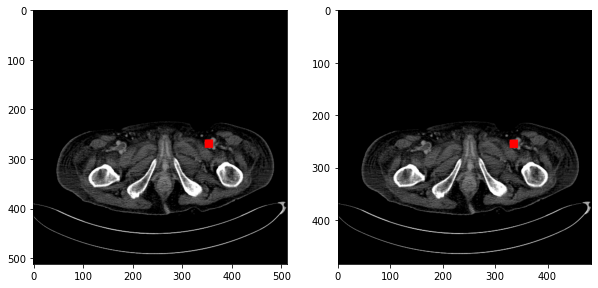

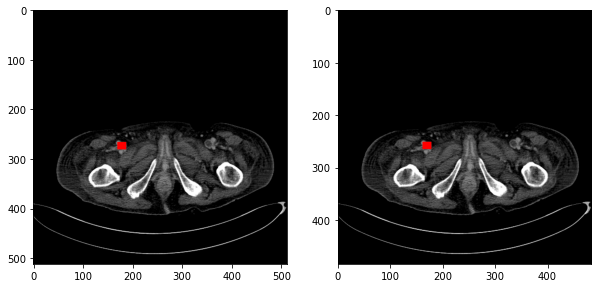

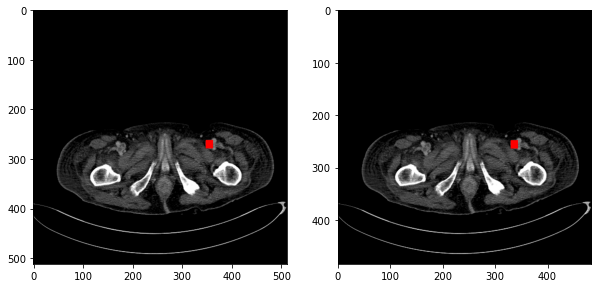

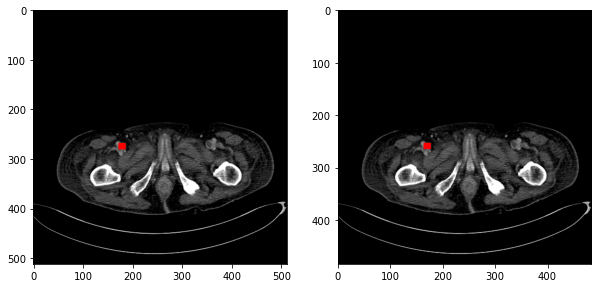

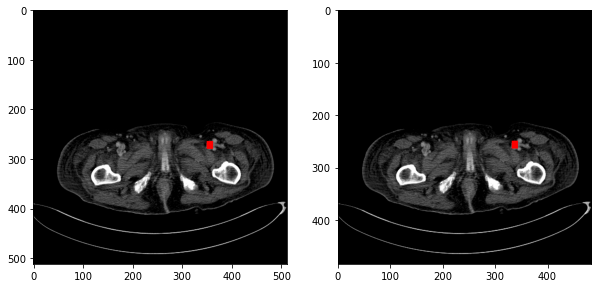

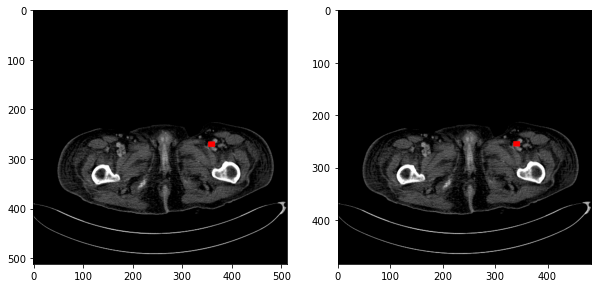

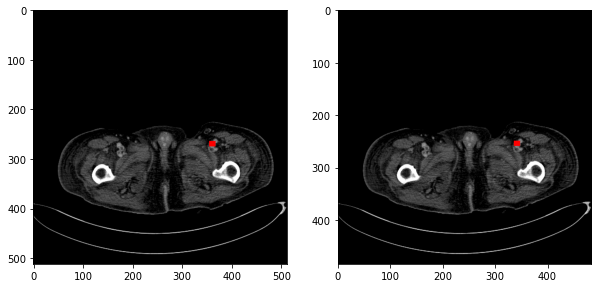

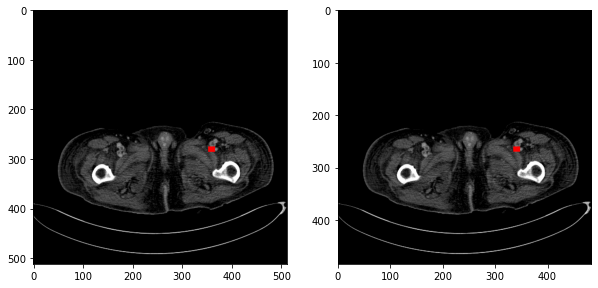

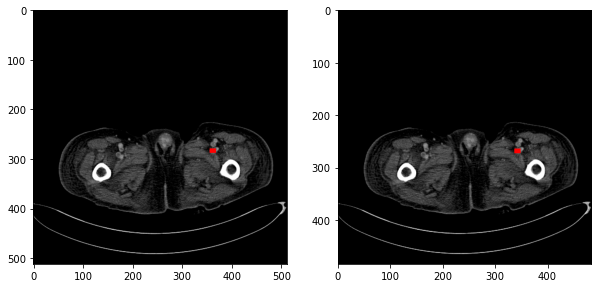

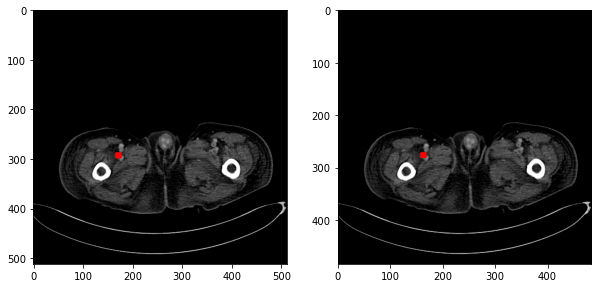

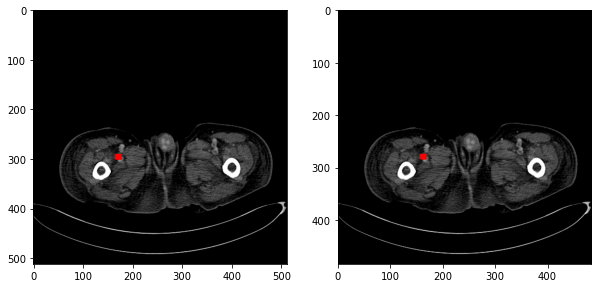

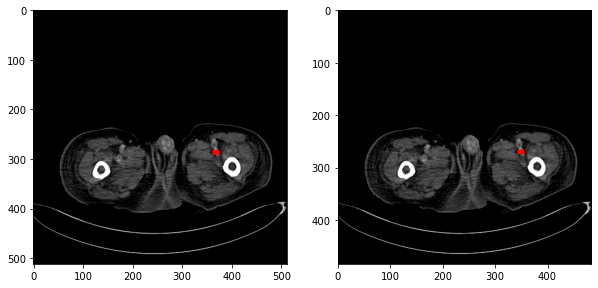

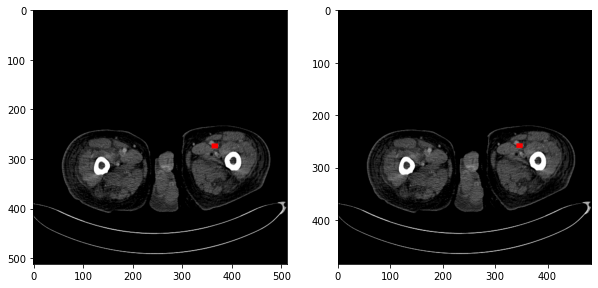

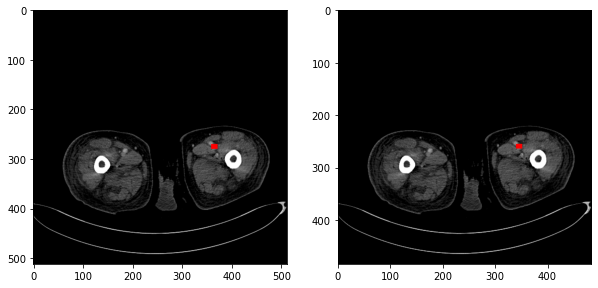

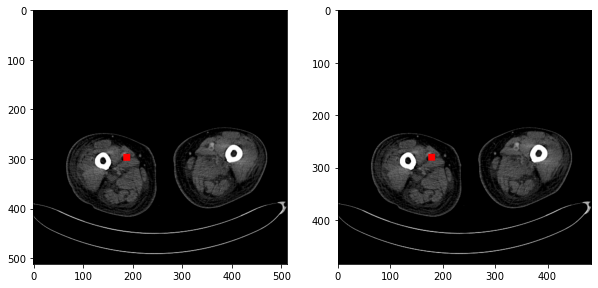

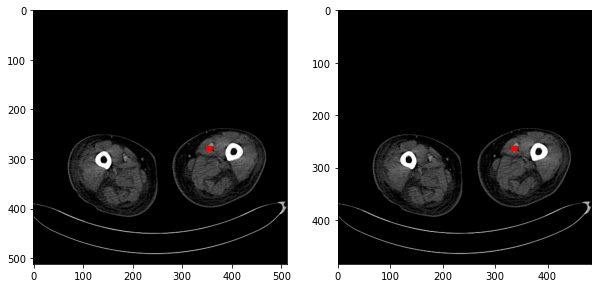

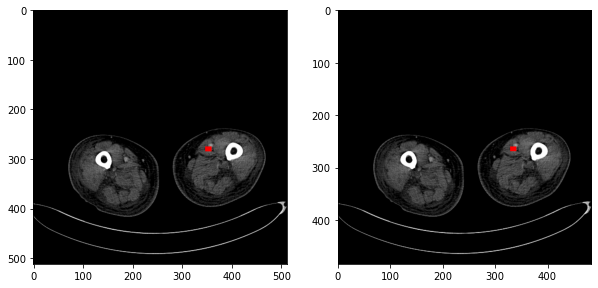

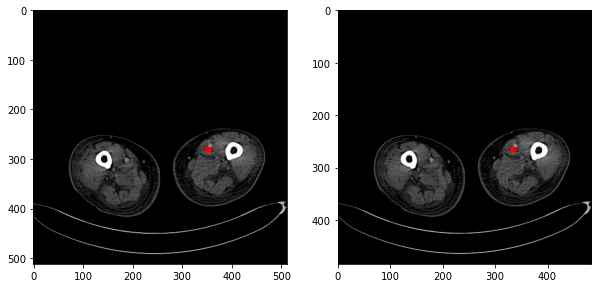

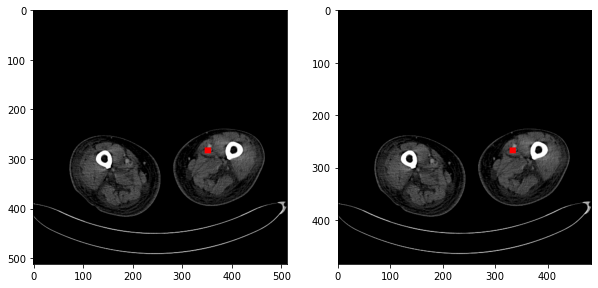

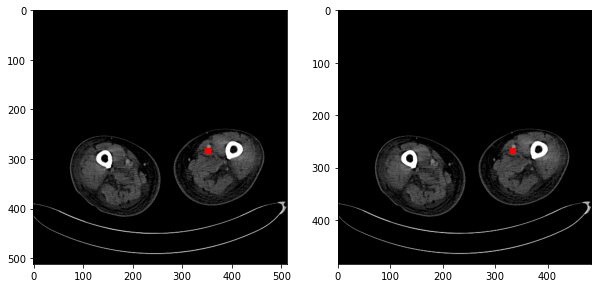

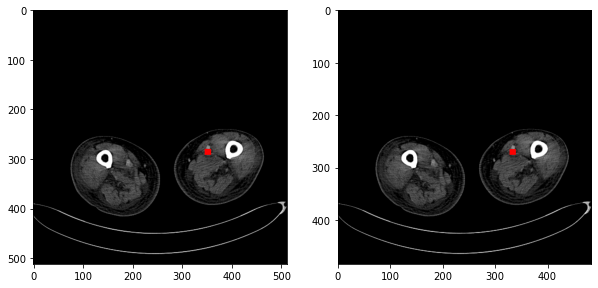

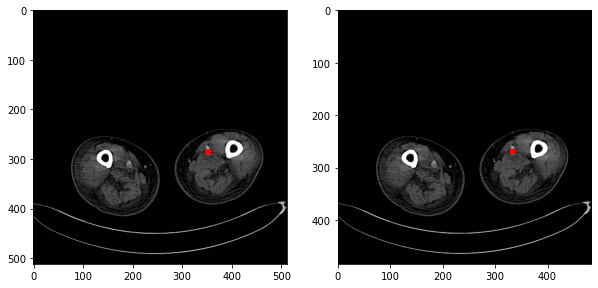

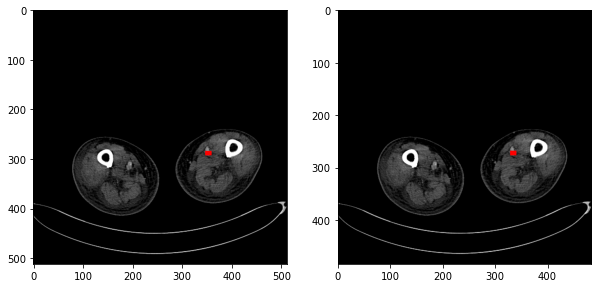

In [35]:
#make roi annot
ReSize= 0.891
datapath = '../../newData/210215'
kinds= 'abnormal'
op = 0
one_p = sorted(glob.glob('../../newData/210215/{}/*'.format(kinds)))
test_save12 = '../../newData/210215/test/test_save12'
test_save16 = '../../newData/210215/test/test_save16'
test_saveElse = '../../newData/210215/test/test_saveElse'

p_name=one_p[op].split('\\')[-1][:8]

#########
folder_name = one_p[op].split('\\')[-1]

roi_zip =  read_roi_zip(datapath+'/'+kinds+'/'+folder_name+'/'+kinds+'.zip')
odKey = list(OrderedDict(roi_zip).keys())
odk = 0
print(odKey[odk], len(odKey))
print(roi_zip[odKey[odk]])
print(roi_zip[odKey[odk]]['position'])
print(roi_zip[odKey[odk]]['left'])
print(roi_zip[odKey[odk]]['top'])
print(dcm_vol.GetSpacing()[0]/ReSize)
print(roi_zip[odKey[odk]]['width'], round(roi_zip[odKey[odk]]['width']*(dcm_vol.GetSpacing()[0]/ReSize)))

spacing_scale = dcm_vol.GetSpacing()[0]/ReSize
for odk in range(len(odKey)):
    match_num = roi_zip[odKey[odk]]['position'] -1 ##########
    # print(start_point,end_point)
    if start_point<= match_num and end_point>= match_num:
        # print(match_num)

        width = roi_zip[odKey[odk]]['width']
        height = roi_zip[odKey[odk]]['height']
        left = roi_zip[odKey[odk]]['left']
        top = roi_zip[odKey[odk]]['top']

        re_width = round(width*spacing_scale)
        re_height = round(height*spacing_scale)
        re_left = round(left*spacing_scale)
        re_top = round(top*spacing_scale)

        if re_width >= 12 or re_height >= 12:
            color_reAnnot= cv2.cvtColor(recon_dcm_array[match_num], cv2.COLOR_GRAY2RGB)
            color_annot= cv2.cvtColor(origin_dcm_array[match_num], cv2.COLOR_GRAY2RGB)
            # print(recon_dcm_array[match_num].shape, color_annot.shape)

            ########x,y 
            # color_reAnnot[re_left:re_left+re_width, re_top: re_top+re_height,0]=255
            # color_reAnnot[re_left:re_left+re_width, re_top: re_top+re_height,1]=0
            # color_reAnnot[re_left:re_left+re_width, re_top: re_top+re_height,2]=0

            # color_annot[left:left+width, top: top+height,0]=255
            # color_annot[left:left+width, top: top+height,1]=0
            # color_annot[left:left+width, top: top+height,2]=0

            #######y,x
            color_reAnnot[re_top: re_top+re_height,re_left:re_left+re_width,0]=255
            color_reAnnot[re_top: re_top+re_height,re_left:re_left+re_width, 1]=0
            color_reAnnot[re_top: re_top+re_height,re_left:re_left+re_width, 2]=0

            color_annot[top: top+height,left:left+width, 0]=255
            color_annot[top: top+height,left:left+width, 1]=0
            color_annot[top: top+height,left:left+width, 2]=0
            # cv2.rectangle(recon_dcm_array[match_num], ())
            plt.figure(figsize=(10,20))
            plt.subplot(1,2,1)
            plt.imshow(color_annot)
            plt.subplot(1,2,2)
            plt.imshow(color_reAnnot)           

            io.imsave(test_save12+'/'+p_name+'_'+str(match_num)+'.png', 
            recon_dcm_array[match_num][re_top: re_top+re_height,re_left:re_left+re_width])
            if re_width >= 16 or re_height >= 16:
                io.imsave(test_save16+'/'+p_name+'_'+str(match_num)+'.png', 
                recon_dcm_array[match_num][re_top: re_top+re_height,re_left:re_left+re_width])
        else:
            # pass
            io.imsave(test_saveElse+'/'+p_name+'_'+str(match_num)+'.png', 
            recon_dcm_array[match_num][re_top: re_top+re_height,re_left:re_left+re_width])


In [110]:
def making_dvtAnnotation(infoList, *args, sheet_1 = 'DVT_origin', sheet_2= 'DVT_add_180', sheet_3= 'Normal_180', datapath, ReSize_spacing, kinds, savePath, ww = 400, wl = 140):

    global dcm_Study_date, start_point, end_point
    # dcm_Study_date = 0
    # start_point=0 
    # end_point = 0
    save12 = '{}/save12/{}'.format(savePath,kinds)
    save16 = '{}/save16/{}'.format(savePath,kinds)
    saveElse = '{}/saveElse/{}'.format(savePath,kinds)
    saveImage = '{}/image/{}'.format(savePath,kinds)
    resize_12 = '{}/resize_deep/save12/{}'.format(savePath,kinds)
    resize_16 = '{}/resize_deep/save16/{}'.format(savePath,kinds)
    resize_else = '{}/resize_deep/saveElse/{}'.format(savePath,kinds)

    dvt_list_origin = pd.read_excel(infoList, engine='openpyxl',sheet_name=sheet_1)
    dvt_list_add = pd.read_excel(infoList, engine='openpyxl',sheet_name=sheet_2)
    dvt_list_normal = pd.read_excel(infoList, engine='openpyxl',sheet_name=sheet_3)

    one_p = sorted(glob.glob(datapath+'/'+ kinds+'/*'))

    # all_array = np.zeros((len(one_p)))

    for op in range(len(one_p)):
        p_name=one_p[op].split('\\')[-1][:8]
        folder_name = one_p[op].split('\\')[-1]

        # dcm_list = sorted(glob.glob('../../newData/210215/abnormal/{}/*.dcm'.format(p_name)))
        dcm_list = sorted(glob.glob(datapath+'/'+kinds+'/'+folder_name+'/*.dcm'))

        dcm_vol = sitk.ReadImage(dcm_list)

        origin_dcm = resample_img(dcm_vol, out_spacing=[dcm_vol.GetSpacing()[0], dcm_vol.GetSpacing()[1], dcm_vol.GetSpacing()[2]], is_label=False)
        recon_dcm = resample_img(dcm_vol, out_spacing=[ReSize_spacing, ReSize_spacing, dcm_vol.GetSpacing()[2]], is_label=False)
        recon_dcm_array = win_scale(sitk.GetArrayFromImage(recon_dcm), wl, ww, np.uint8, (0,255))
        origin_dcm_array = win_scale(sitk.GetArrayFromImage(origin_dcm), wl, ww, np.uint8, (0,255))

        # os.makedirs(saveImage+'/'+p_name, exist_ok=True)

        # for saveI in range(len(dcm_list)):
        #     io.imsave(saveImage+'/'+p_name+'/'+str(saveI)+'.png', recon_dcm_array[saveI])


        file_reader = sitk.ImageFileReader()
        file_reader.SetFileName(dcm_list[0])
        file_reader.ReadImageInformation()
        # start_point = 0
        # end_point = 0

        if kinds!= 'normal':
            ##################  origin data
            # print('abnormal')                                                                      
            if len(one_p[op].split('\\')[-1])<11:
                print('abnormal origin')
                one_id_index = dvt_list_origin.index[dvt_list_origin['ID'] == int(p_name)]
                # for oi in one_id_index:
                if len(one_p[op].split('\\')[-1])<9:
                    print('abnormal origin only id')
                    start_point = dvt_list_origin['시작'][one_id_index[0]]
                    end_point = dvt_list_origin['끝'][one_id_index[0]]

                else:
                    print('abnormal origin overlap')
                    dcm_Study_date = file_reader.GetMetaData('0018|1200')
                    for oi in range(len(one_id_index)):
                        if dvt_list_origin['Study Date'][one_id_index[oi]].date().strftime('%Y%m%d')== str(dcm_Study_date):
                            start_point = dvt_list_origin['시작'][one_id_index[oi]]
                            end_point = dvt_list_origin['끝'][one_id_index[oi]]
                        else:
                            start_point = start_point
                            end_point = end_point                           
                            # continue
                
            ##################  add data 
            else:
                print('abnormal add')
                one_id_index = dvt_list_add.index[dvt_list_add['ID'] == int(p_name)]
                
                file_Study_date = one_p[op].split('\\')[-1][9:]
                dcm_Study_date = file_reader.GetMetaData('0018|1200')
                for oi in range(len(one_id_index)):
                    if dvt_list_add['Study Date'][one_id_index[oi]].date().strftime('%Y%m%d')== str(dcm_Study_date):
                        start_point = dvt_list_add['시작'][one_id_index[oi]]
                        end_point = dvt_list_add['끝'][one_id_index[oi]]
                    else:
                        start_point = start_point
                        end_point = end_point                         
                        # continue
        ##################  normal data            
        else:
            # print('normal')
            if len(one_p[op].split('\\')[-1])<11:
                print('normal origin')
                one_id_index = dvt_list_origin.index[dvt_list_origin['ID'] == int(p_name)]
                # for oi in one_id_index:
                if len(one_id_index) == 0:
                    print(len(one_id_index))
                if len(one_p[op].split('\\')[-1])<9:
                    print('normal origin only id')
                    start_point = dvt_list_origin['시작'][one_id_index[0]]
                    end_point = dvt_list_origin['끝'][one_id_index[0]]

                else:
                    print('normal origin overlap')
                    dcm_Study_date = file_reader.GetMetaData('0018|1200')
                    for oi in range(len(one_id_index)):
                        
                        if dvt_list_add['Study Date'][one_id_index[oi]].date().strftime('%Y%m%d')== str(dcm_Study_date):
                            start_point = dvt_list_origin['시작'][one_id_index[oi]]
                            end_point = dvt_list_origin['끝'][one_id_index[oi]]
                        else:
                            start_point = start_point
                            end_point = end_point   
                            # continue
            else:
                print('normal_add')                                
                one_id_index = dvt_list_normal.index[dvt_list_normal['ID'] == int(p_name)]
                print(one_id_index, int(p_name))
                file_Study_date = one_p[op].split('\\')[-1][9:]
                dcm_Study_date = file_reader.GetMetaData('0018|1200')
                for oi in range(len(one_id_index)):
                    print(oi)
                    print(one_id_index[oi])
                    print(dvt_list_normal['Study Date'][one_id_index[oi]].date().strftime('%Y%m%d'), str(dcm_Study_date))
                    if dvt_list_normal['Study Date'][one_id_index[oi]].date().strftime('%Y%m%d')== str(dcm_Study_date):
                        start_point = dvt_list_normal['시작'][one_id_index[oi]]
                        end_point = dvt_list_normal['끝'][one_id_index[oi]]
                        print(start_point, end_point)
                    else:
                        print('no match with index')
                        # start_point = start_point
                        # end_point = end_point   
                        continue
        print('{} = start point:{}, end point:{}, file_Study_date:{}, dcm_Study_date:{}'.format(folder_name,start_point,end_point,file_Study_date, dcm_Study_date))

        roi_zip =  read_roi_zip(datapath+'/'+kinds+'/'+folder_name+'/'+kinds+'.zip')
        odKey = list(OrderedDict(roi_zip).keys())

        spacing_scale = dcm_vol.GetSpacing()[0]/ReSize_spacing

        # npy_array = np.zeros((ReSize_deep, ReSize_deep))
        for odk in range(len(odKey)):
            match_num = roi_zip[odKey[odk]]['position'] -1 ##########
            # print(start_point,end_point)
            if start_point<= match_num and end_point>= match_num:
                # print(match_num)

                width = roi_zip[odKey[odk]]['width']
                height = roi_zip[odKey[odk]]['height']
                left = roi_zip[odKey[odk]]['left']
                top = roi_zip[odKey[odk]]['top']

                re_width = round(width*spacing_scale)
                re_height = round(height*spacing_scale)
                re_left = round(left*spacing_scale)
                re_top = round(top*spacing_scale)

                # re_scale = ReSize_deep/max(re_width, re_height)


                if re_width >= 12 or re_height >= 12:
        
                    io.imsave(save12+'/'+p_name+'_'+str(match_num)+'.png', 
                    recon_dcm_array[match_num][re_top: re_top+re_height,re_left:re_left+re_width])
                    if re_width >= 16 or re_height >= 16:
                        io.imsave(save16+'/'+p_name+'_'+str(match_num)+'.png', 
                        recon_dcm_array[match_num][re_top: re_top+re_height,re_left:re_left+re_width])
                else:
                    # pass
                    io.imsave(saveElse+'/'+p_name+'_'+str(match_num)+'.png', 
                    recon_dcm_array[match_num][re_top: re_top+re_height,re_left:re_left+re_width])
        print('{} done'.format(folder_name))
    print('Making data is done')


In [105]:
making_dvtAnnotation('../../newData/DVT_list_210215.xlsx', datapath='../../newData/210215', ReSize_spacing =  0.891, kinds= 'normal', savePath = '../../newData/210215/Spacing891_image', ww = 400, wl = 140)

620453_2 done
normal origin
normal origin overlap
27620453_3 = start point:59, end point:180, file_Study_date:200708, dcm_Study_date:20200128
27620453_3 done
normal origin
normal origin only id
28008733 = start point:38, end point:127, file_Study_date:200708, dcm_Study_date:20200128
28008733 done
normal_add
Int64Index([], dtype='int64') 28434713
28434713_201105 = start point:38, end point:127, file_Study_date:201105, dcm_Study_date:20201105
28434713_201105 done
normal origin
normal origin only id
28543743 = start point:34, end point:128, file_Study_date:201105, dcm_Study_date:20201105
28543743 done
normal origin
normal origin only id
28611923 = start point:52, end point:139, file_Study_date:201105, dcm_Study_date:20201105
28611923 done
normal origin
normal origin only id
28738643 = start point:42, end point:137, file_Study_date:201105, dcm_Study_date:20201105
28738643 done
normal origin
normal origin only id
28744283 = start point:34, end point:130, file_Study_date:201105, dcm_Study_da

KeyError: 182

In [112]:
making_dvtAnnotation('../../newData/DVT_list_210215.xlsx', datapath='../../newData/210215', ReSize_spacing =  0.891, kinds= 'abnormal', savePath = '../../newData/210215/Spacing891_image', ww = 400, wl = 140)

only id
27051893 = start point:53, end point:141, file_Study_date:200708, dcm_Study_date:20200708
27051893 done
abnormal origin
abnormal origin only id
27259563 = start point:43, end point:134, file_Study_date:200708, dcm_Study_date:20200708
27259563 done
abnormal origin
abnormal origin only id
27374393 = start point:46, end point:154, file_Study_date:200708, dcm_Study_date:20200708
27374393 done
abnormal origin
abnormal origin only id
27620453 = start point:59, end point:180, file_Study_date:200708, dcm_Study_date:20200708
27620453 done
abnormal origin
abnormal origin overlap
27620453_2 = start point:42, end point:159, file_Study_date:200708, dcm_Study_date:20200212
27620453_2 done
abnormal origin
abnormal origin overlap
27620453_3 = start point:46, end point:167, file_Study_date:200708, dcm_Study_date:20200128
27620453_3 done
abnormal origin
abnormal origin only id
28008733 = start point:38, end point:127, file_Study_date:200708, dcm_Study_date:20200128
28008733 done
abnormal add
284